In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.rcParams['figure.figsize'] = (18, 6)

sns.set_style("whitegrid")

PATH  = "../Networks/"

In [2]:
dir_reg   = re.compile(r'.*Networks/(.+)_Student_Networks/saved/(student_\d)_([^\/]+)\/(.+)')
err_reg   = re.compile(r'Err:  (\d\.\d+)')

series = {}

for dirpath, dirnames, filenames in os.walk(PATH):

    mtch    = dir_reg.match(dirpath)

    if mtch:

        try:
            with open(dirpath+"/log.txt", "r") as f:
                raw_log = f.readlines()

            dataset, net, config, algo = mtch.group(1), mtch.group(2), mtch.group(3), mtch.group(4)

            if dataset not in series:
                series[dataset] = {}

            if net not in series[dataset]:
                series[dataset][net] = {}

            if config not in series[dataset][net]:
                series[dataset][net][config] = []

            err = pd.Series(err_reg.findall(" ".join(raw_log)), dtype=float)
            
            series[dataset][net][config].append((algo, err))

        except IOError:
            print dirpath, "has no log file."

In [3]:
df    = pd.DataFrame()

for dataset in ["CIFAR_10", "Top_Down"]:
    for net in series[dataset].keys():
        for config in series[dataset][net].keys():
            for algo, data in series[dataset][net][config]:
                col_name = "{0} {1} {2} {3}".format(dataset, net, config, algo)
                df[col_name] = data
                
df.columns

Index([u'CIFAR_10 student_1 N2_H32 reg_logits',
       u'CIFAR_10 student_1 N2_H32 know_dist_T5.0_beta0.05',
       u'CIFAR_10 student_1 N2_H32 baseline',
       u'CIFAR_10 student_1 N2_H64 reg_logits',
       u'CIFAR_10 student_1 N2_H64 know_dist_T5.0_beta0.05',
       u'CIFAR_10 student_1 N2_H64 baseline',
       u'CIFAR_10 student_1 N1_H32 reg_logits',
       u'CIFAR_10 student_1 N1_H32 know_dist_T5.0_beta0.05',
       u'CIFAR_10 student_1 N1_H32 baseline',
       u'Top_Down student_1 7_10 reg_logits',
       u'Top_Down student_1 7_10 know_dist_T5.0_beta0.05',
       u'Top_Down student_1 7_10 baseline',
       u'Top_Down student_1 15_20 reg_logits',
       u'Top_Down student_1 15_20 know_dist_T5.0_beta0.05',
       u'Top_Down student_1 15_20 baseline',
       u'Top_Down student_1 10_15 reg_logits',
       u'Top_Down student_1 10_15 know_dist_T5.0_beta0.05',
       u'Top_Down student_1 10_15 baseline',
       u'Top_Down student_2 18 baseline_hint_based',
       u'Top_Down student_2 1

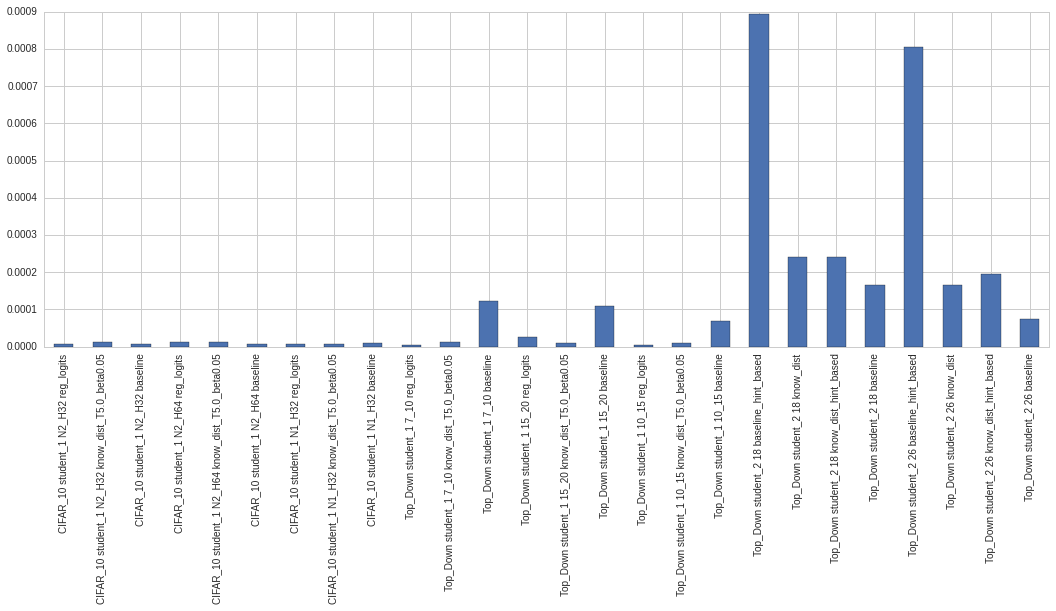

In [73]:
df.iloc[80:,:].var().plot(kind='bar')

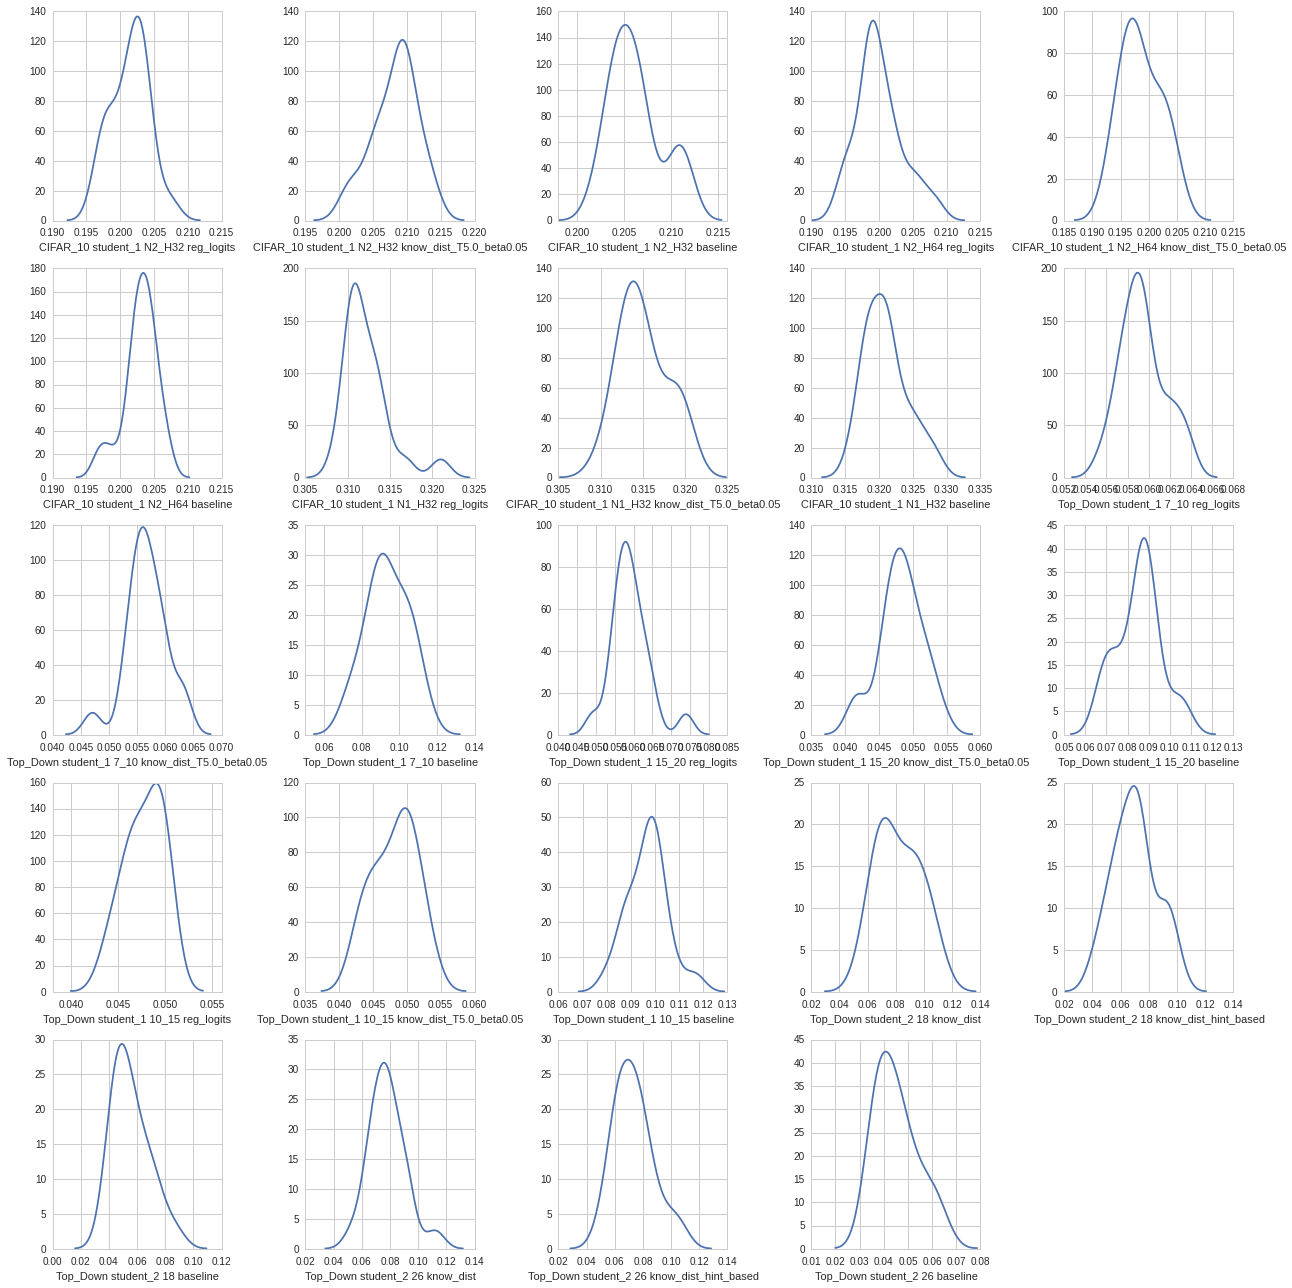

In [48]:
from statsmodels.graphics.gofplots import qqplot

plt.rcParams['figure.figsize'] = (18, 18)
fig = plt.figure()
i=0
for col in df.columns:
    if re.match(r'Top_Down student_2 \d\d baseline_hint_based', col): continue
        
    i+=1
    ax = fig.add_subplot(5, 5, i)
    sns.distplot(df[col].iloc[80:], hist=False, ax=ax)
    
plt.tight_layout()

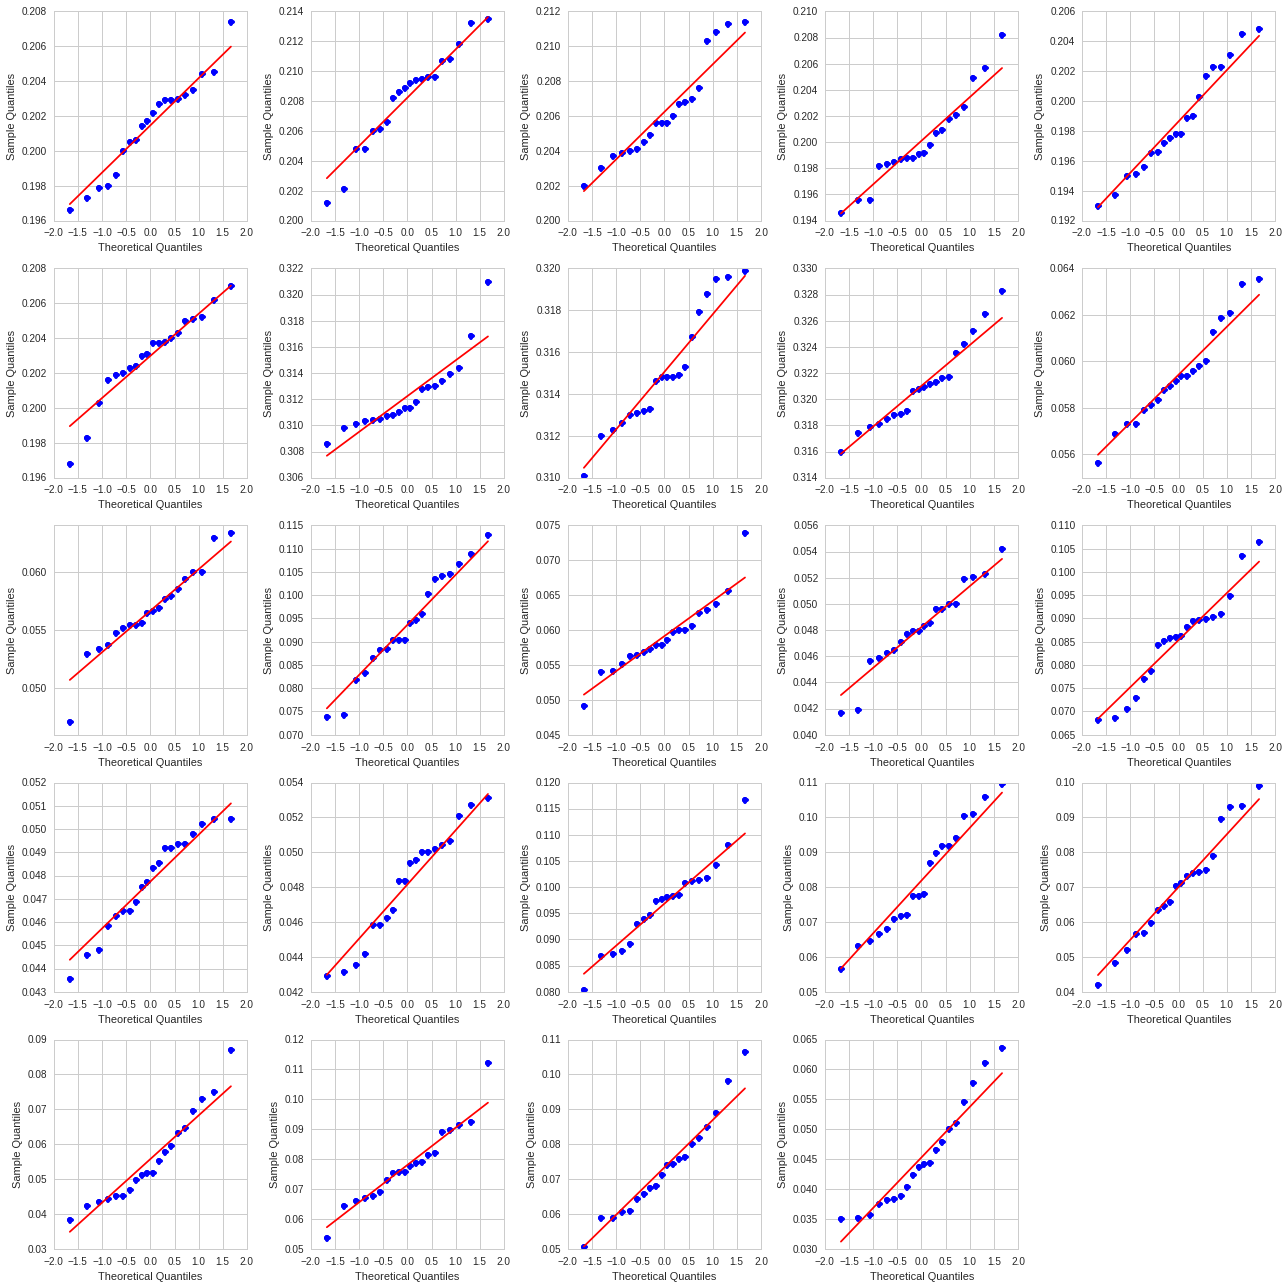

In [41]:
from statsmodels.graphics.gofplots import qqplot

plt.rcParams['figure.figsize'] = (18, 18)
fig = plt.figure()
i=0
for col in df.columns:
    if re.match(r'Top_Down student_2 \d\d baseline_hint_based', col): continue
        
    i+=1
    ax = fig.add_subplot(5, 5, i)
    qqplot(df[col].iloc[80:], line='s', ax=ax)
    
plt.tight_layout()

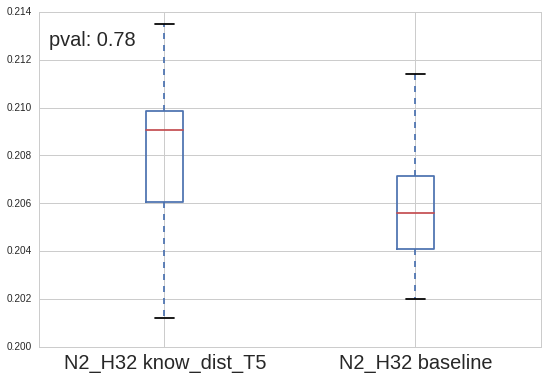

In [102]:
plt.rcParams['figure.figsize'] = (9, 6)

reg = re.compile(r'CIFAR_10 student_1 (N2\w+32 \w+).*')
reg2 = re.compile(r'CIFAR_10 student_1 (N2\w+32 reg).*')

df1 = df[[col for col in df.columns if reg.match(col) and not reg2.match(col)]].copy()
df1.columns = [reg.match(col).group(1) for col in df1.columns]

#from scipy.stats import f_oneway
#f_score, p_val = f_oneway(*[df1[col] for col in df1.columns])

from scipy.stats import kruskal
statistic, p_val = kruskal(*[df1[col] for col in df1.columns])


ax = df1.iloc[80:].boxplot(fontsize=20)

ax.annotate('pval: {0:.2g}'.format(p_val), (0.02,0.9), xycoords='axes fraction', fontsize=20)

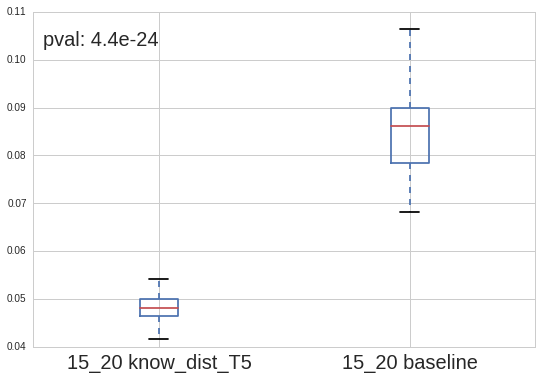

In [112]:
plt.rcParams['figure.figsize'] = (9, 6)

reg = re.compile(r'Top_Down student_1 (15\w+ \w+).*')
reg2 = re.compile(r'Top_Down student_1 (15\w+ reg).*')

df1 = df[[col for col in df.columns if reg.match(col) and not reg2.match(col)]].copy()
df1.columns = [reg.match(col).group(1) for col in df1.columns]

from scipy.stats import kruskal
statistic, p_val = kruskal(*[df1[col] for col in df1.columns])


ax = df1.iloc[80:].boxplot(fontsize=20)

ax.annotate('pval: {0:.2g}'.format(p_val), (0.02,0.9), xycoords='axes fraction', fontsize=20)

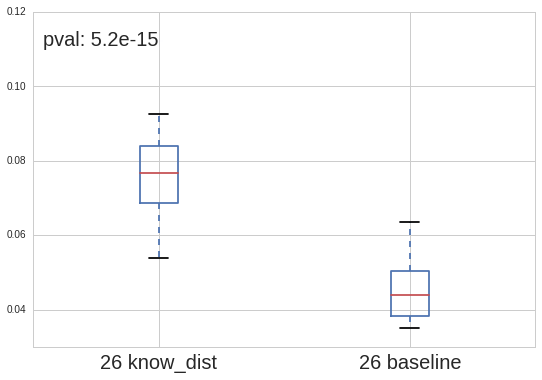

In [160]:
plt.rcParams['figure.figsize'] = (9, 6)

reg  = re.compile(r'Top_Down student_2 (26 \w+).*')
reg2 = re.compile(r'Top_Down student_2 \d\d \w+hint_based$.*')
#reg2 = re.compile(r'Top_Down student_2 \d\d know_dist$.*')
reg3 = re.compile(r'Top_Down student_2 \d\d baseline_hint_based')

df1 = df[[col for col in df.columns if reg.match(col) and not reg2.match(col) and not reg3.match(col)]].copy()
df1.columns = [reg.match(col).group(1) for col in df1.columns]

from scipy.stats import kruskal
statistic, p_val = kruskal(*[df1[col] for col in df1.columns])


ax = df1.iloc[80:].boxplot(fontsize=20)

ax.annotate('pval: {0:.2g}'.format(p_val), (0.02,0.9), xycoords='axes fraction', fontsize=20)

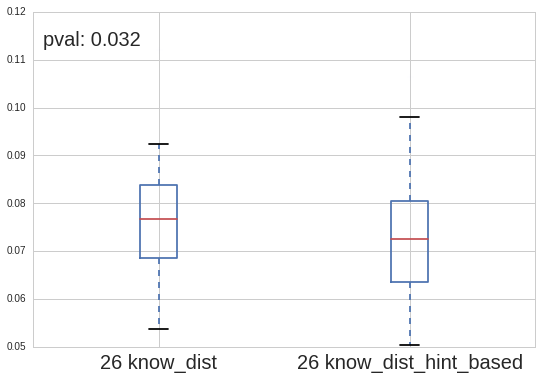

In [164]:
plt.rcParams['figure.figsize'] = (9, 6)

reg  = re.compile(r'Top_Down student_2 (26 \w+).*')
reg2 = re.compile(r'Top_Down student_2 \d\d baseline$.*')
reg3 = re.compile(r'Top_Down student_2 \d\d baseline_hint_based')

df1 = df[[col for col in df.columns if reg.match(col) and not reg2.match(col) and not reg3.match(col)]].copy()
df1.columns = [reg.match(col).group(1) for col in df1.columns]

from scipy.stats import kruskal
statistic, p_val = kruskal(*[df1[col] for col in df1.columns])


ax = df1.iloc[80:].boxplot(fontsize=20)

ax.annotate('pval: {0:.2g}'.format(p_val), (0.02,0.9), xycoords='axes fraction', fontsize=20)